# 1. Preprocessing and feature extraction

(20000, 28, 28)
(5000, 28, 28)


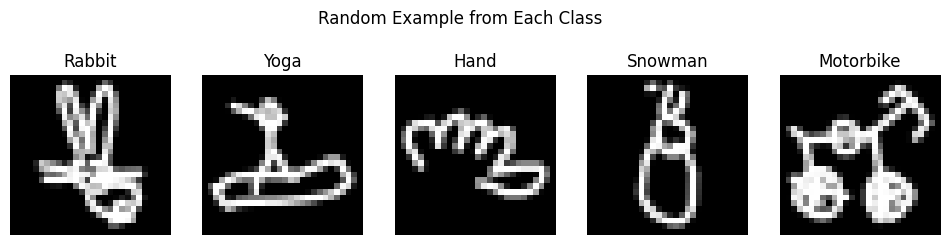

In [ ]:
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)

## Labels

## The integer labels correspond to the following classes:
## - 0: rabbit
## - 1: yoga
## - 2: hand
## - 3: snowman
## - 4: motorbike

class_names = ['Rabbit', 'Yoga', 'Hand', 'Snowman', 'Motorbike']

plt.figure(figsize=(12, 3))
for class_id in range(5):
    indices = np.where(train_labels == class_id)[0]
    random_idx = np.random.choice(indices)
    plt.subplot(1, 5, class_id + 1)
    plt.imshow(train_images[random_idx], cmap='gray')
    plt.title(f"{class_names[class_id]}")
    plt.axis('off')
plt.suptitle("Random Example from Each Class")
plt.show()

In [2]:
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("Training Set Class Counts:")
for i in range(5):
    print(f"{class_names[i]:<10}: {train_counts[i]}")

print("\nTest Set Class Counts:")
for i in range(5):
    print(f"{class_names[i]:<10}: {test_counts[i]}")


Training Set Class Counts:
Rabbit    : 4000
Yoga      : 4000
Hand      : 4000
Snowman   : 4000
Motorbike : 4000

Test Set Class Counts:
Rabbit    : 1000
Yoga      : 1000
Hand      : 1000
Snowman   : 1000
Motorbike : 1000


In [3]:
def extract_features(images):
    features = []
    for img in images:
        # hog features
        hog_features = hog(img, orientations=12, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=False, feature_vector=True)
        features.append(hog_features)

    return np.array(features)

train_features = extract_features(train_images)
test_features = extract_features(test_images)

print(train_features.shape)
print(test_features.shape)

(20000, 588)
(5000, 588)


## Intra-Class Variations

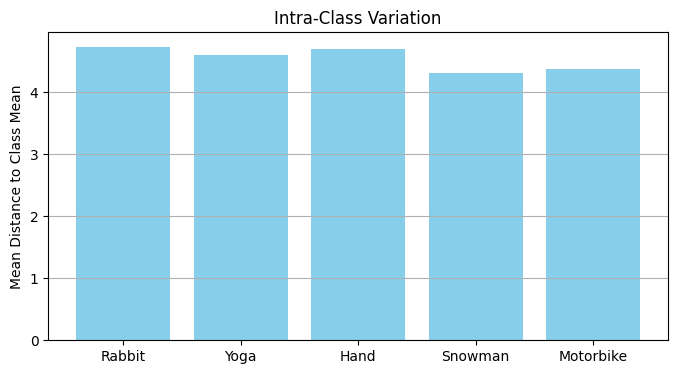

In [4]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

intra_variations = []

for class_id in range(5):
    class_features = train_features[train_labels == class_id]
    class_mean = np.mean(class_features, axis=0)
    mean_dist = np.mean([euclidean(f, class_mean) for f in class_features])
    intra_variations.append(mean_dist)

# Plot
plt.figure(figsize=(8, 4))
plt.bar(class_names, intra_variations, color='skyblue')
plt.ylabel("Mean Distance to Class Mean")
plt.title("Intra-Class Variation")
plt.grid(axis='y')
plt.show()


## Inter-Class Similarity

In [5]:
class_centroids = []
for class_id in range(5):
    class_features = train_features[train_labels == class_id]
    centroid = np.mean(class_features, axis=0)
    class_centroids.append(centroid)

print("Inter-Class Distances (Centroid-to-Centroid):\n")
for (i, j) in combinations(range(5), 2):
    dist = euclidean(class_centroids[i], class_centroids[j])
    print(f"{class_names[i]:<10} vs {class_names[j]:<10} -> Distance: {dist:.4f}")


Inter-Class Distances (Centroid-to-Centroid):

Rabbit     vs Yoga       -> Distance: 1.4509
Rabbit     vs Hand       -> Distance: 1.5256
Rabbit     vs Snowman    -> Distance: 1.6532
Rabbit     vs Motorbike  -> Distance: 2.3065
Yoga       vs Hand       -> Distance: 1.5787
Yoga       vs Snowman    -> Distance: 2.0242
Yoga       vs Motorbike  -> Distance: 1.6974
Hand       vs Snowman    -> Distance: 2.2801
Hand       vs Motorbike  -> Distance: 2.2967
Snowman    vs Motorbike  -> Distance: 3.0103


# 2. k-NN Model

In [7]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict(X_train, y_train, X_test, k=3, distance_fn=euclidean_distance):
    predictions = []
    for test_vector in X_test:
        distances = [distance_fn(test_vector, train_vector) for train_vector in X_train]
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]
        most_common = Counter(k_labels).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)

def knn_predict_fast(X_train, y_train, X_test, k=3):
    predictions = []

    X_train_sq = np.sum(X_train ** 2, axis=1)
    for x in X_test:
        dists = np.sqrt(X_train_sq - 2 * np.dot(X_train, x) + np.sum(x ** 2))
        k_indices = np.argpartition(dists, k)[:k]
        k_labels = y_train[k_indices]
        most_common = Counter(k_labels).most_common(1)[0][0]
        predictions.append(most_common)
    return np.array(predictions)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

for k in [1, 3, 5, 7, 9]:
    y_pred = knn_predict_fast(train_features, train_labels, test_features, k=k)
    acc = accuracy(test_labels, y_pred)
    print(f"k: {k}, Accuracy: {acc:.4f}")

k: 1, Accuracy: 0.8376
k: 3, Accuracy: 0.8510
k: 5, Accuracy: 0.8546
k: 7, Accuracy: 0.8574
k: 9, Accuracy: 0.8602


# 3. Gaussian Naive Bayes

In [8]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_stats = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.class_stats[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-6 # prevent division by zero
            }
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _gaussian_pdf(self, x, mean, var):
        return -0.5 * np.sum(np.log(2. * np.pi * var) + ((x - mean) ** 2) / var)

    def predict(self, X):
        preds = []
        for x in X:
            posteriors = []
            for c in self.classes:
                mean = self.class_stats[c]['mean']
                var = self.class_stats[c]['var']
                log_likelihood = self._gaussian_pdf(x, mean, var)
                log_prior = np.log(self.priors[c])
                posterior = log_prior + log_likelihood
                posteriors.append(posterior)
            preds.append(self.classes[np.argmax(posteriors)])
        return np.array(preds)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [9]:
gnb = GaussianNaiveBayes()
gnb.fit(train_features, train_labels)
acc = gnb.score(test_features, test_labels)
print(f"Gaussian Naive Bayes Test Accuracy: {acc:.4f}")

Gaussian Naive Bayes Test Accuracy: 0.6292


# 4. Logistic Regression Model

In [10]:
class SoftmaxRegression:
    def __init__(self, lr=0.1, max_iter=500, reg_lambda=0.0):
        self.lr = lr
        self.max_iter = max_iter
        self.reg_lambda = reg_lambda
        self.train_losses = []
        self.test_losses = []

    def _softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y, num_classes):
        return np.eye(num_classes)[y]

    def _cross_entropy_loss(self, probs, y_one_hot):
        n = probs.shape[0]
        log_likelihood = -np.log(probs + 1e-9) * y_one_hot
        return np.sum(log_likelihood) / n

    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_features = X.shape
        self.num_classes = np.max(y) + 1
        self.W = np.zeros((n_features, self.num_classes))
        self.b = np.zeros((1, self.num_classes))
        y_one_hot = self._one_hot(y, self.num_classes)

        if X_val is not None:
            y_val_one_hot = self._one_hot(y_val, self.num_classes)

        for i in range(self.max_iter):
            scores = X @ self.W + self.b
            probs = self._softmax(scores)

            loss = self._cross_entropy_loss(probs, y_one_hot) + (self.reg_lambda / 2) * np.sum(self.W ** 2)
            self.train_losses.append(loss)

            if X_val is not None:
                val_scores = X_val @ self.W + self.b
                val_probs = self._softmax(val_scores)
                val_loss = self._cross_entropy_loss(val_probs, y_val_one_hot) + (self.reg_lambda / 2) * np.sum(self.W ** 2)
                self.test_losses.append(val_loss)

            loss_grad = (1 / n_samples) * (X.T @ (probs - y_one_hot)) + self.reg_lambda * self.W
            bias_grad = (1 / n_samples) * np.sum(probs - y_one_hot, axis=0, keepdims=True)

            self.W -= self.lr * loss_grad
            self.b -= self.lr * bias_grad

    def predict(self, X):
        scores = X @ self.W + self.b
        probs = self._softmax(scores)
        return np.argmax(probs, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


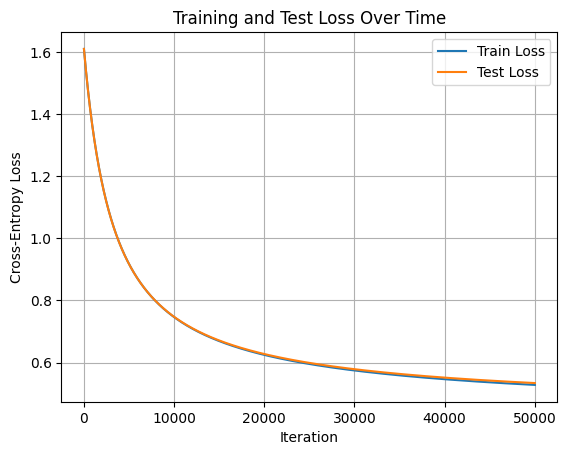

Logistic Regression Accuracy: 0.8308


In [11]:
model = SoftmaxRegression(lr=0.001, max_iter=50000, reg_lambda=1e-3)
model.fit(train_features, train_labels, X_val=test_features, y_val=test_labels)

plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.test_losses, label="Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Test Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

acc = model.score(test_features, test_labels)
print(f"Logistic Regression Accuracy: {acc:.4f}")
